In [14]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [15]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [16]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    print(noOfClasses,class_names, train_generator, validation_generator)
    
    return noOfClasses,class_names, train_generator, validation_generator

In [17]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [18]:
def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    #x = Dropout(0.2)(x)
    #x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [19]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'VGG16.keras', verbose=1, save_best_only=True)
    return model, annealer, checkpoint

In [20]:
def modelFit(model, annealer, checkpoint):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [21]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [22]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)

def saveModel(model, className):
    save_path = "/kaggle/working/" + className + " - VGG16.keras"
    model.save(save_path)
    print("Model saved at:", save_path)

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [24]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [25]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 256
lr = 0.001

for i in classPaths:
    print(i)

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
5 ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi'] <keras.src.preprocessing.image.DirectoryIterator object at 0x79562809b340> <keras.src.preprocessing.image.DirectoryIterator object at 0x79568af62470>
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928   

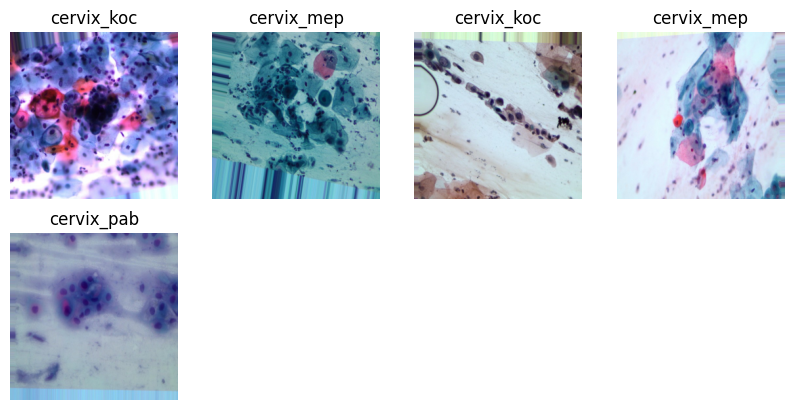

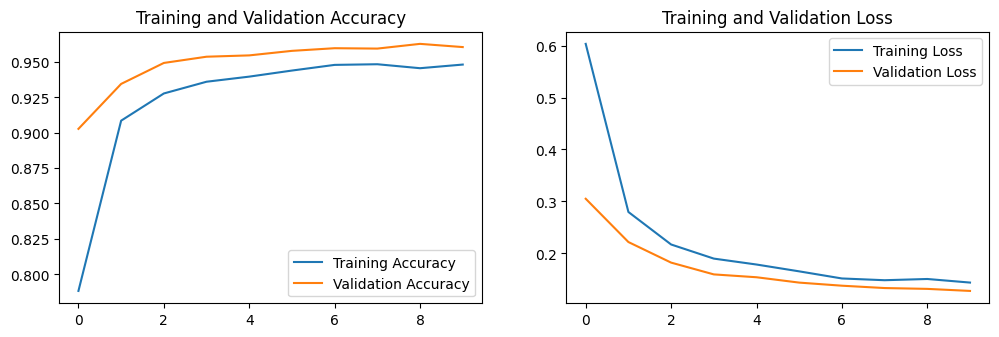

235/235 [==============================] - 23s 100ms/step - loss: 0.1279 - tp: 7157.0000 - fp: 263.0000 - tn: 29737.0000 - fn: 343.0000 - precision: 0.9646 - recall: 0.9543 - accuracy: 0.9604 - auc: 0.9978
Accuracy on the Test Set = 96.04 %
True Positives = 7157.0. True Negatives = 29737.0
False Positives = 263.0. False Negatives = 343.0
Precision = 0.9645552635192871
Recall = 0.9542666673660278
F1 Score = 95.93833820569611
ROC AUC = 0.9977993369102478
Model saved at: /kaggle/working/Cervical Cancer  - VGG16.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 24s 101ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

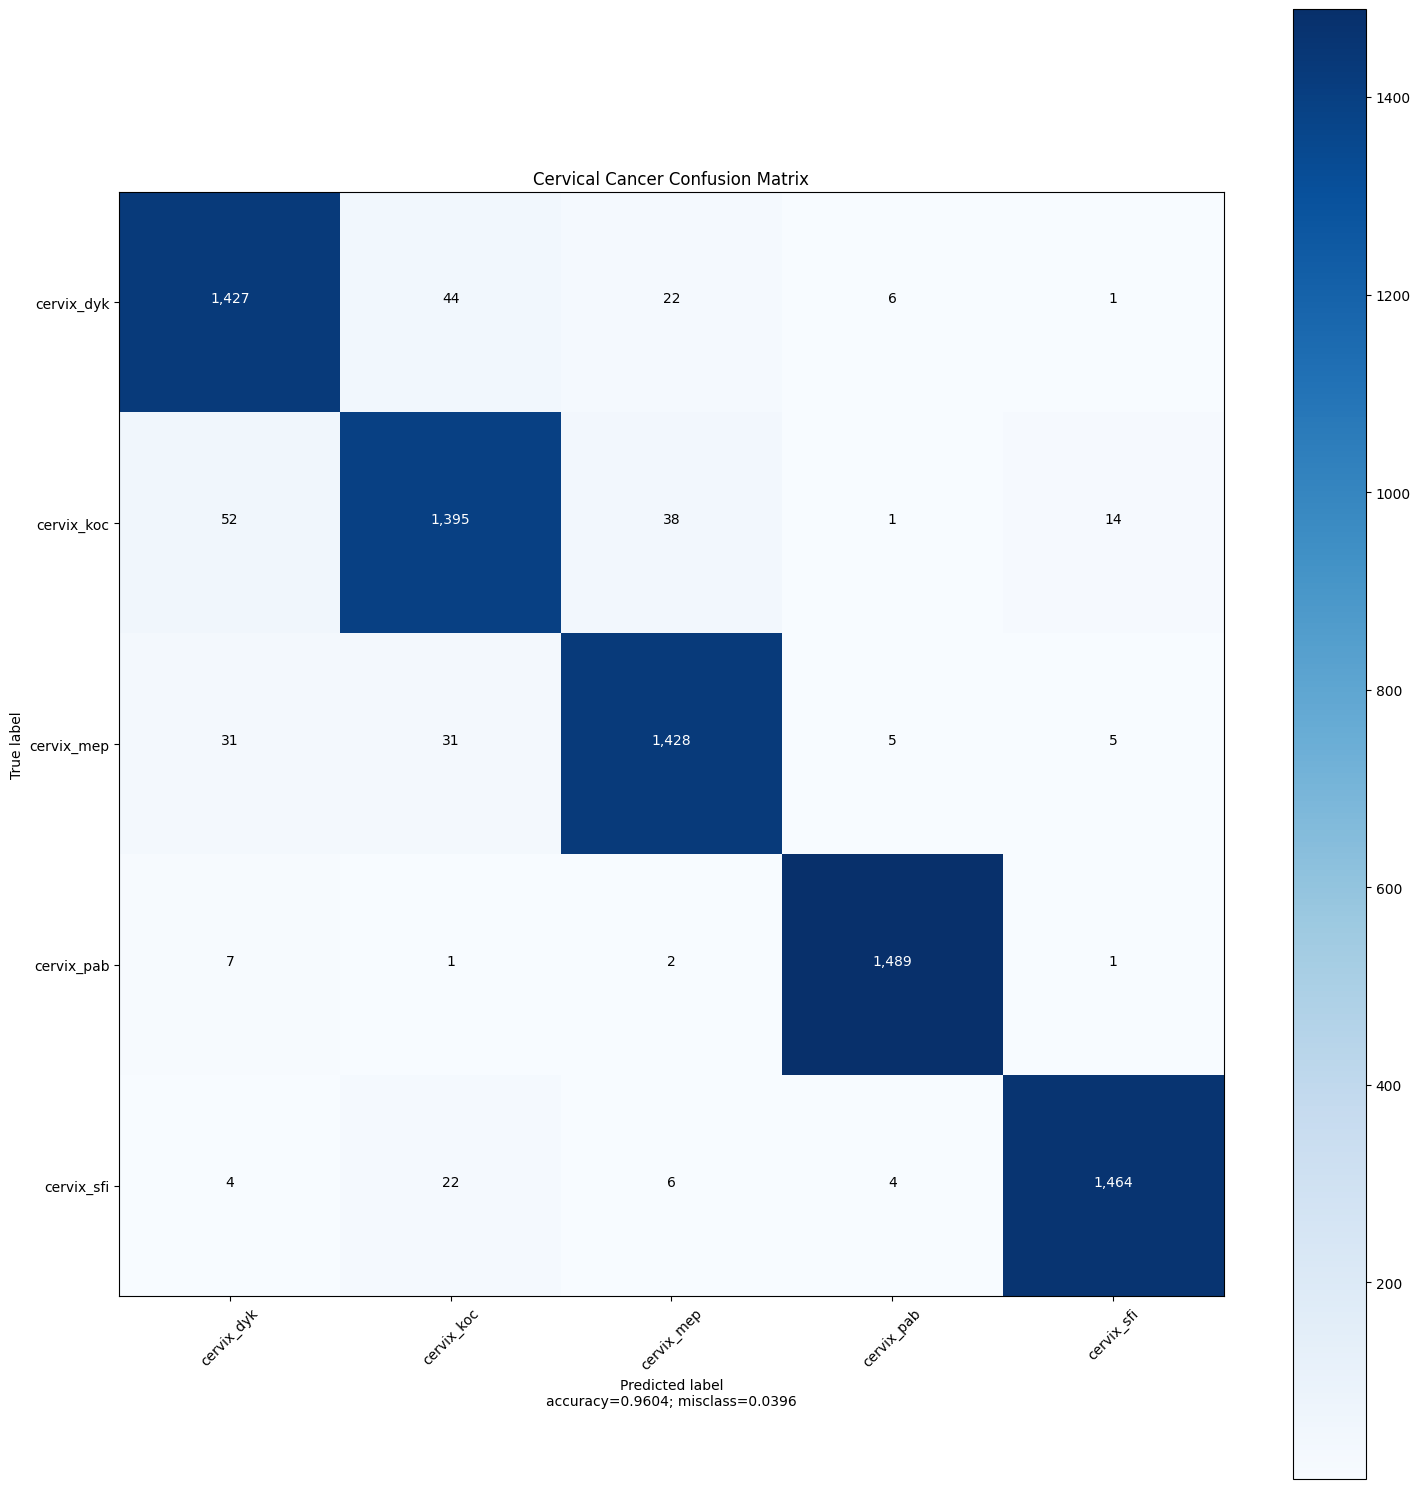

Best Hyperparameters (learning rate, batch size): [9.95284216e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [26]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
5 ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc'] <keras.src.preprocessing.image.DirectoryIterator object at 0x79562809b520> <keras.src.preprocessing.image.DirectoryIterator object at 0x79568b4400a0>
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
             

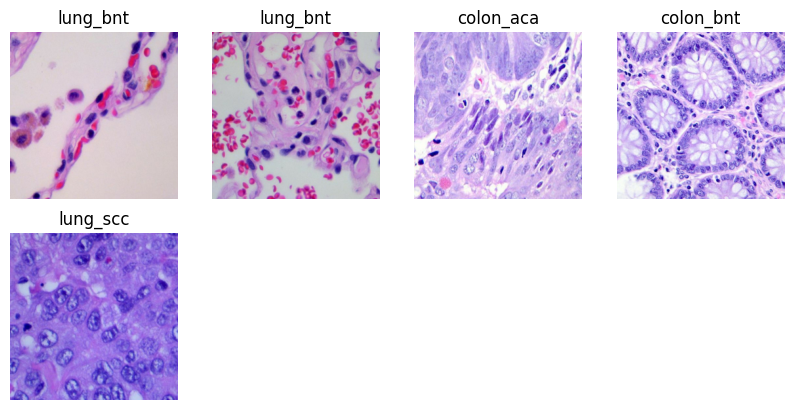

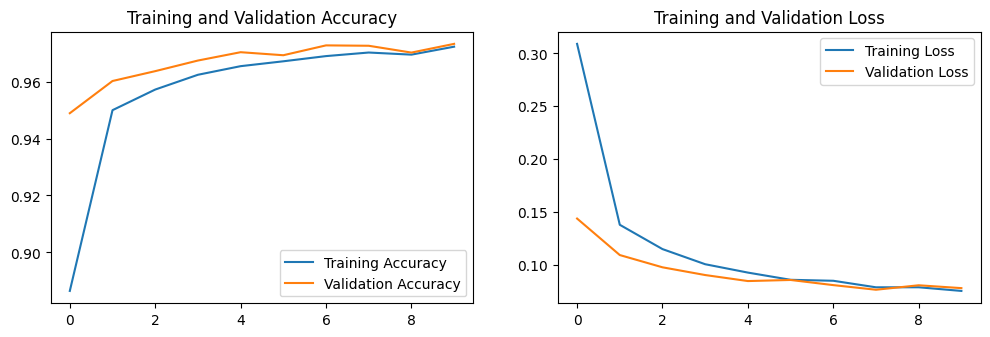

235/235 [==============================] - 26s 110ms/step - loss: 0.0777 - tp: 7295.0000 - fp: 194.0000 - tn: 29806.0000 - fn: 205.0000 - precision: 0.9741 - recall: 0.9727 - accuracy: 0.9733 - auc: 0.9986
Accuracy on the Test Set = 97.33 %
True Positives = 7295.0. True Negatives = 29806.0
False Positives = 194.0. False Negatives = 205.0
Precision = 0.974095344543457
Recall = 0.9726666808128357
F1 Score = 97.33804884538117
ROC AUC = 0.998614490032196
Model saved at: /kaggle/working/Lung and Colon Cancer  - VGG16.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 25s 107ms/step
Predicted :  [0 0 0 ... 4 1 0]


<Figure size 640x480 with 0 Axes>

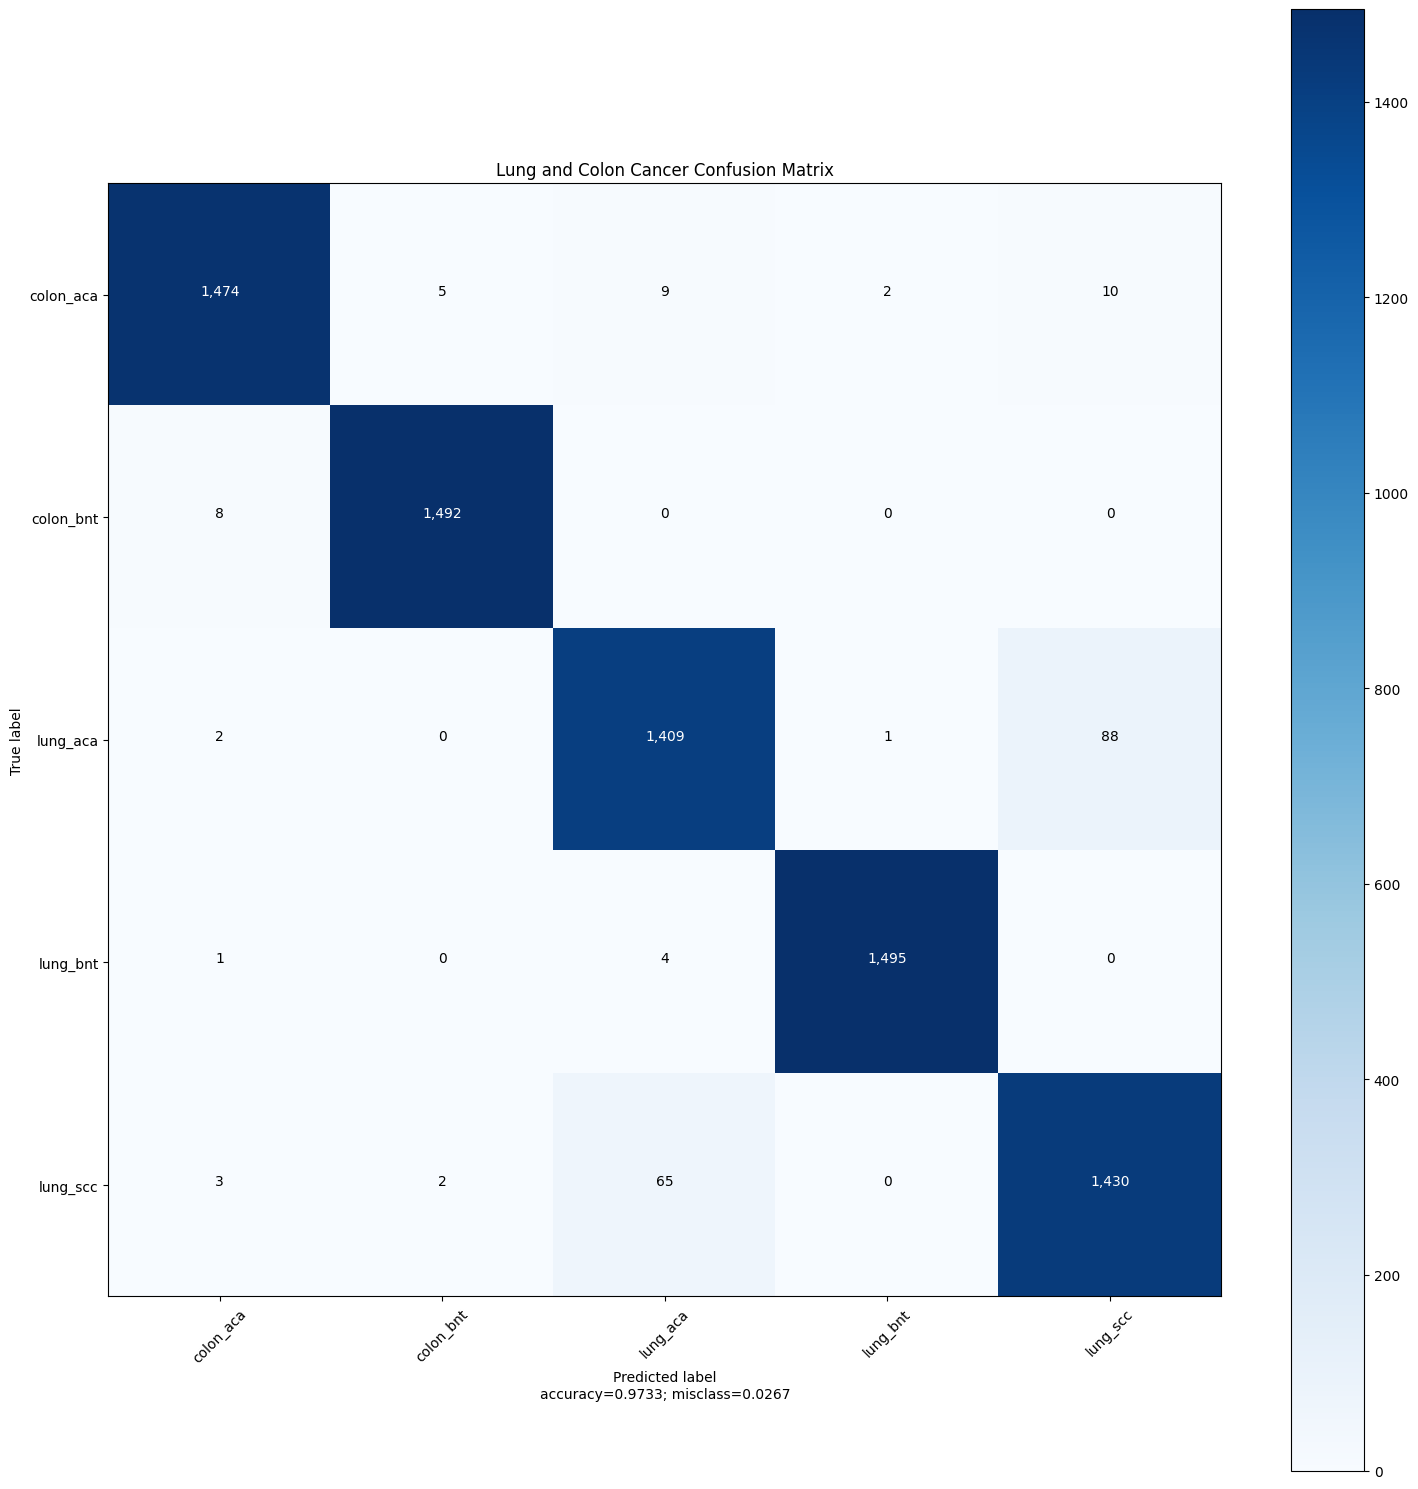

Best Hyperparameters (learning rate, batch size): [9.95284992e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [27]:
className = 'Lung and Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
2 ['oral_normal', 'oral_scc'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7952045d4880> <keras.src.preprocessing.image.DirectoryIterator object at 0x79568b43e320>
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxP

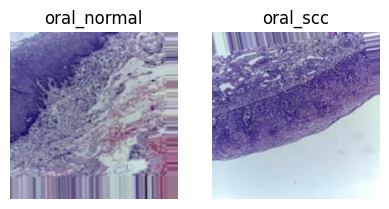

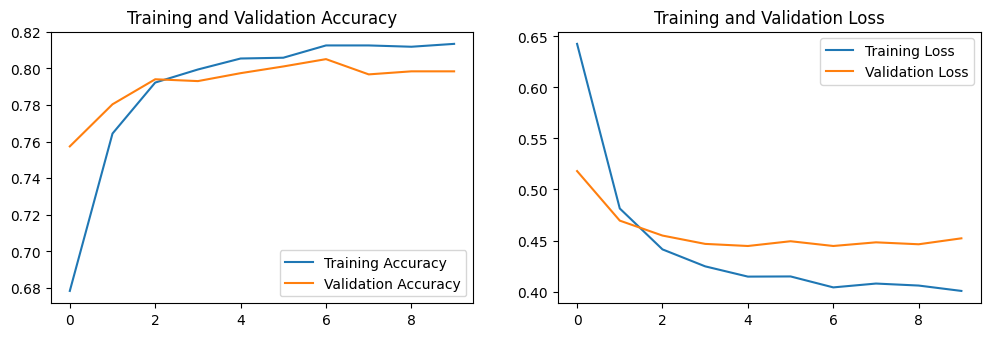

94/94 [==============================] - 10s 104ms/step - loss: 0.4522 - tp: 2395.0000 - fp: 605.0000 - tn: 2395.0000 - fn: 605.0000 - precision: 0.7983 - recall: 0.7983 - accuracy: 0.7983 - auc: 0.8799
Accuracy on the Test Set = 79.83 %
True Positives = 2395.0. True Negatives = 2395.0
False Positives = 605.0. False Negatives = 605.0
Precision = 0.7983333468437195
Recall = 0.7983333468437195
F1 Score = 79.83333468437195
ROC AUC = 0.8799145817756653
Model saved at: /kaggle/working/Oral Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 10s 109ms/step
Predicted :  [0 0 1 ... 0 1 0]


<Figure size 640x480 with 0 Axes>

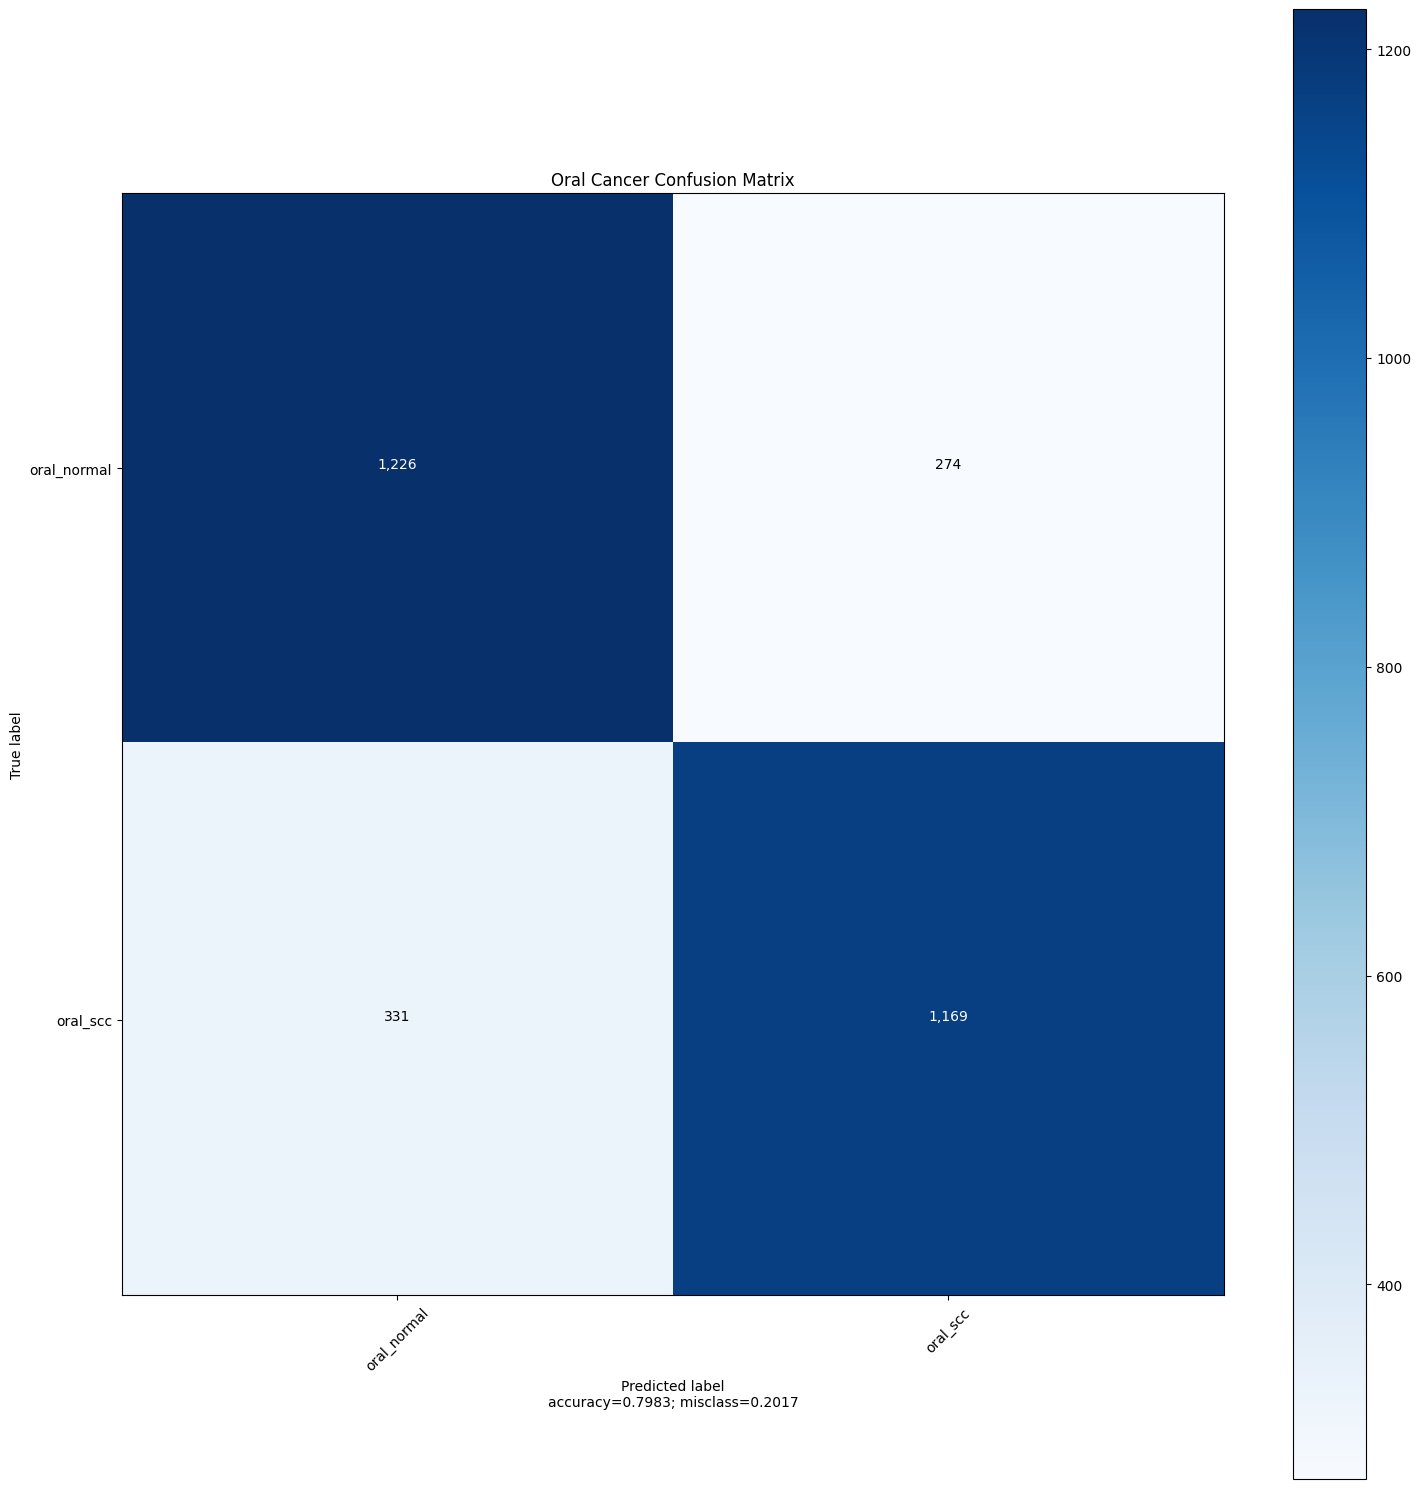

Best Hyperparameters (learning rate, batch size): [9.95284033e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [28]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
4 ['all_benign', 'all_early', 'all_pre', 'all_pro'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7955f4dcb730> <keras.src.preprocessing.image.DirectoryIterator object at 0x7952047c6890>
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                       

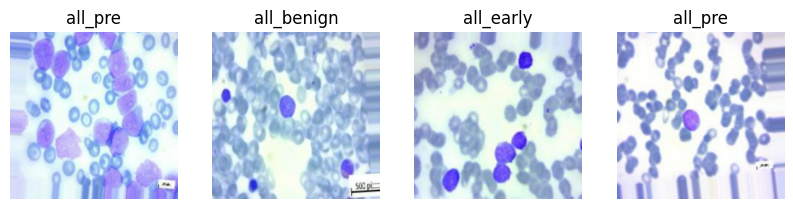

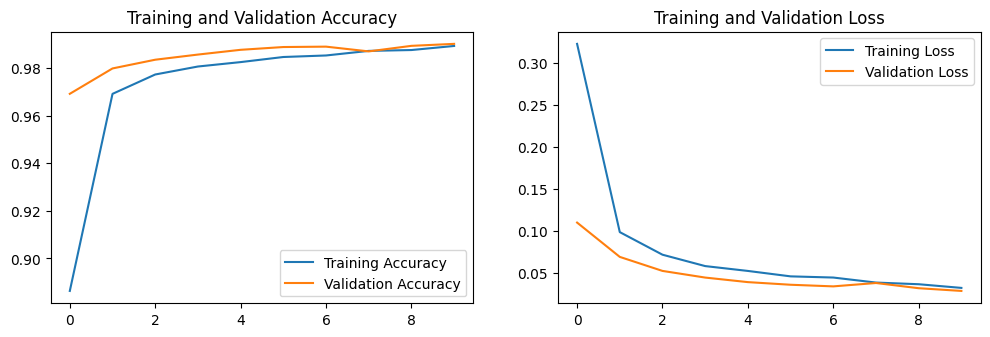

188/188 [==============================] - 17s 92ms/step - loss: 0.0287 - tp: 5938.0000 - fp: 56.0000 - tn: 17944.0000 - fn: 62.0000 - precision: 0.9907 - recall: 0.9897 - accuracy: 0.9902 - auc: 0.9999
Accuracy on the Test Set = 99.02 %
True Positives = 5938.0. True Negatives = 17944.0
False Positives = 56.0. False Negatives = 62.0
Precision = 0.9906573295593262
Recall = 0.9896666407585144
F1 Score = 99.0161737354946
ROC AUC = 0.9998538494110107
Model saved at: /kaggle/working/ALL  - VGG16.keras
True :  [0 0 0 ... 3 3 3]
188/188 [==============================] - 18s 95ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

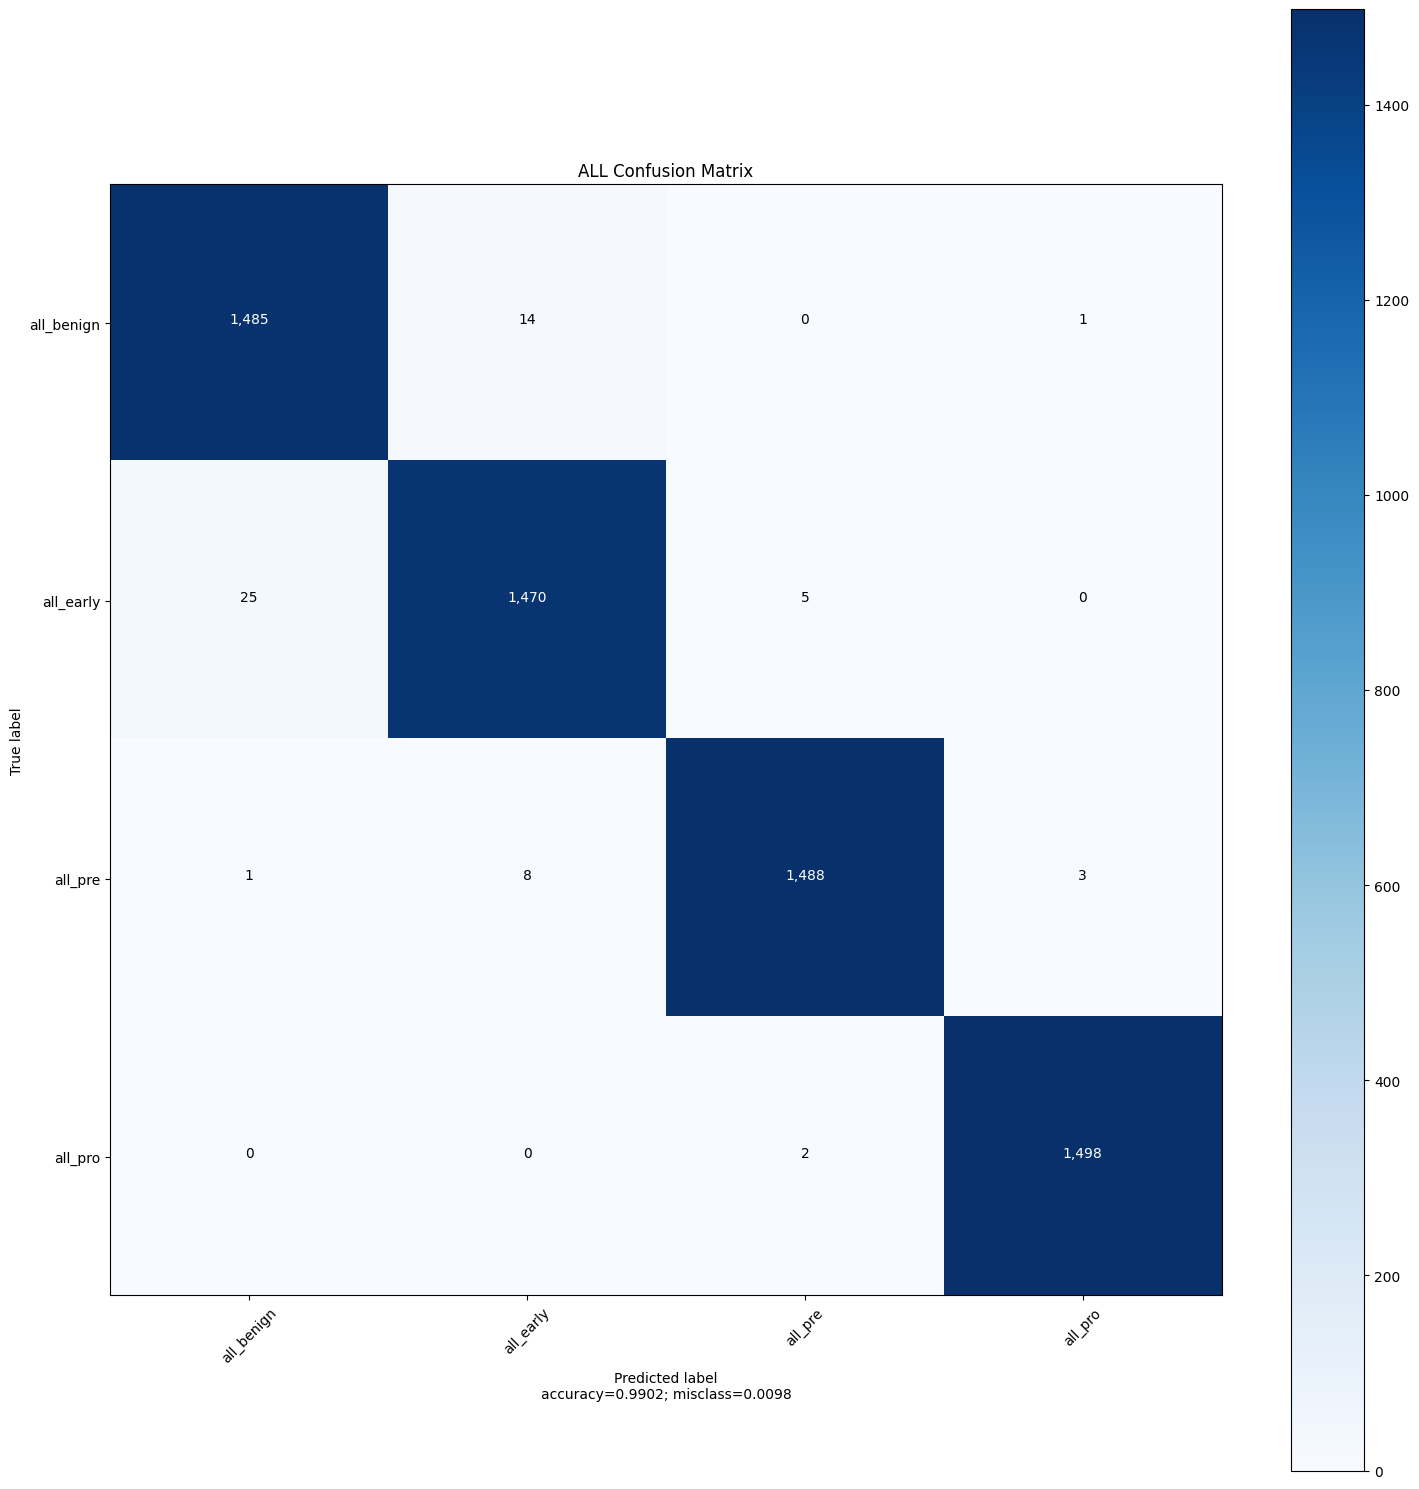

Best Hyperparameters (learning rate, batch size): [9.95284045e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [29]:
className = 'ALL '
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
2 ['kidney_normal', 'kidney_tumor'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7951db0858d0> <keras.src.preprocessing.image.DirectoryIterator object at 0x7951db0aee60>
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block

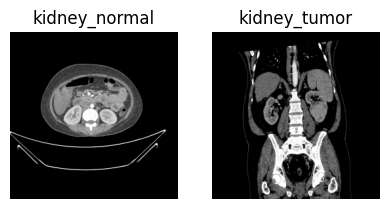

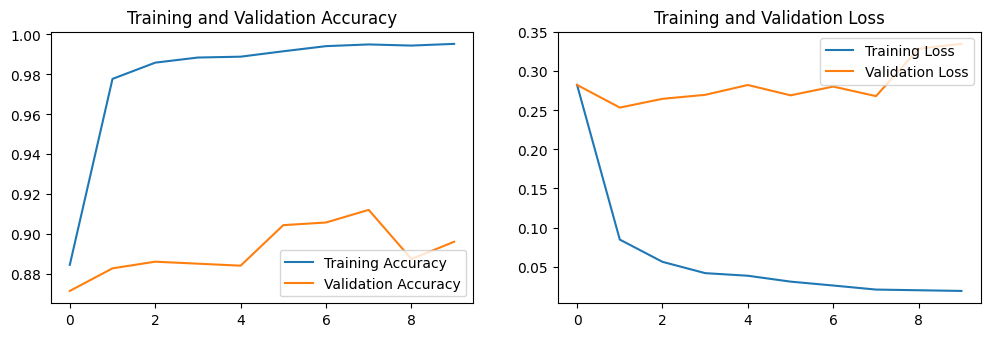

94/94 [==============================] - 9s 91ms/step - loss: 0.3349 - tp: 2688.0000 - fp: 312.0000 - tn: 2688.0000 - fn: 312.0000 - precision: 0.8960 - recall: 0.8960 - accuracy: 0.8960 - auc: 0.9522
Accuracy on the Test Set = 89.60 %
True Positives = 2688.0. True Negatives = 2688.0
False Positives = 312.0. False Negatives = 312.0
Precision = 0.8960000276565552
Recall = 0.8960000276565552
F1 Score = 89.60000276565552
ROC AUC = 0.9521899223327637
Model saved at: /kaggle/working/Kidney Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 9s 90ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

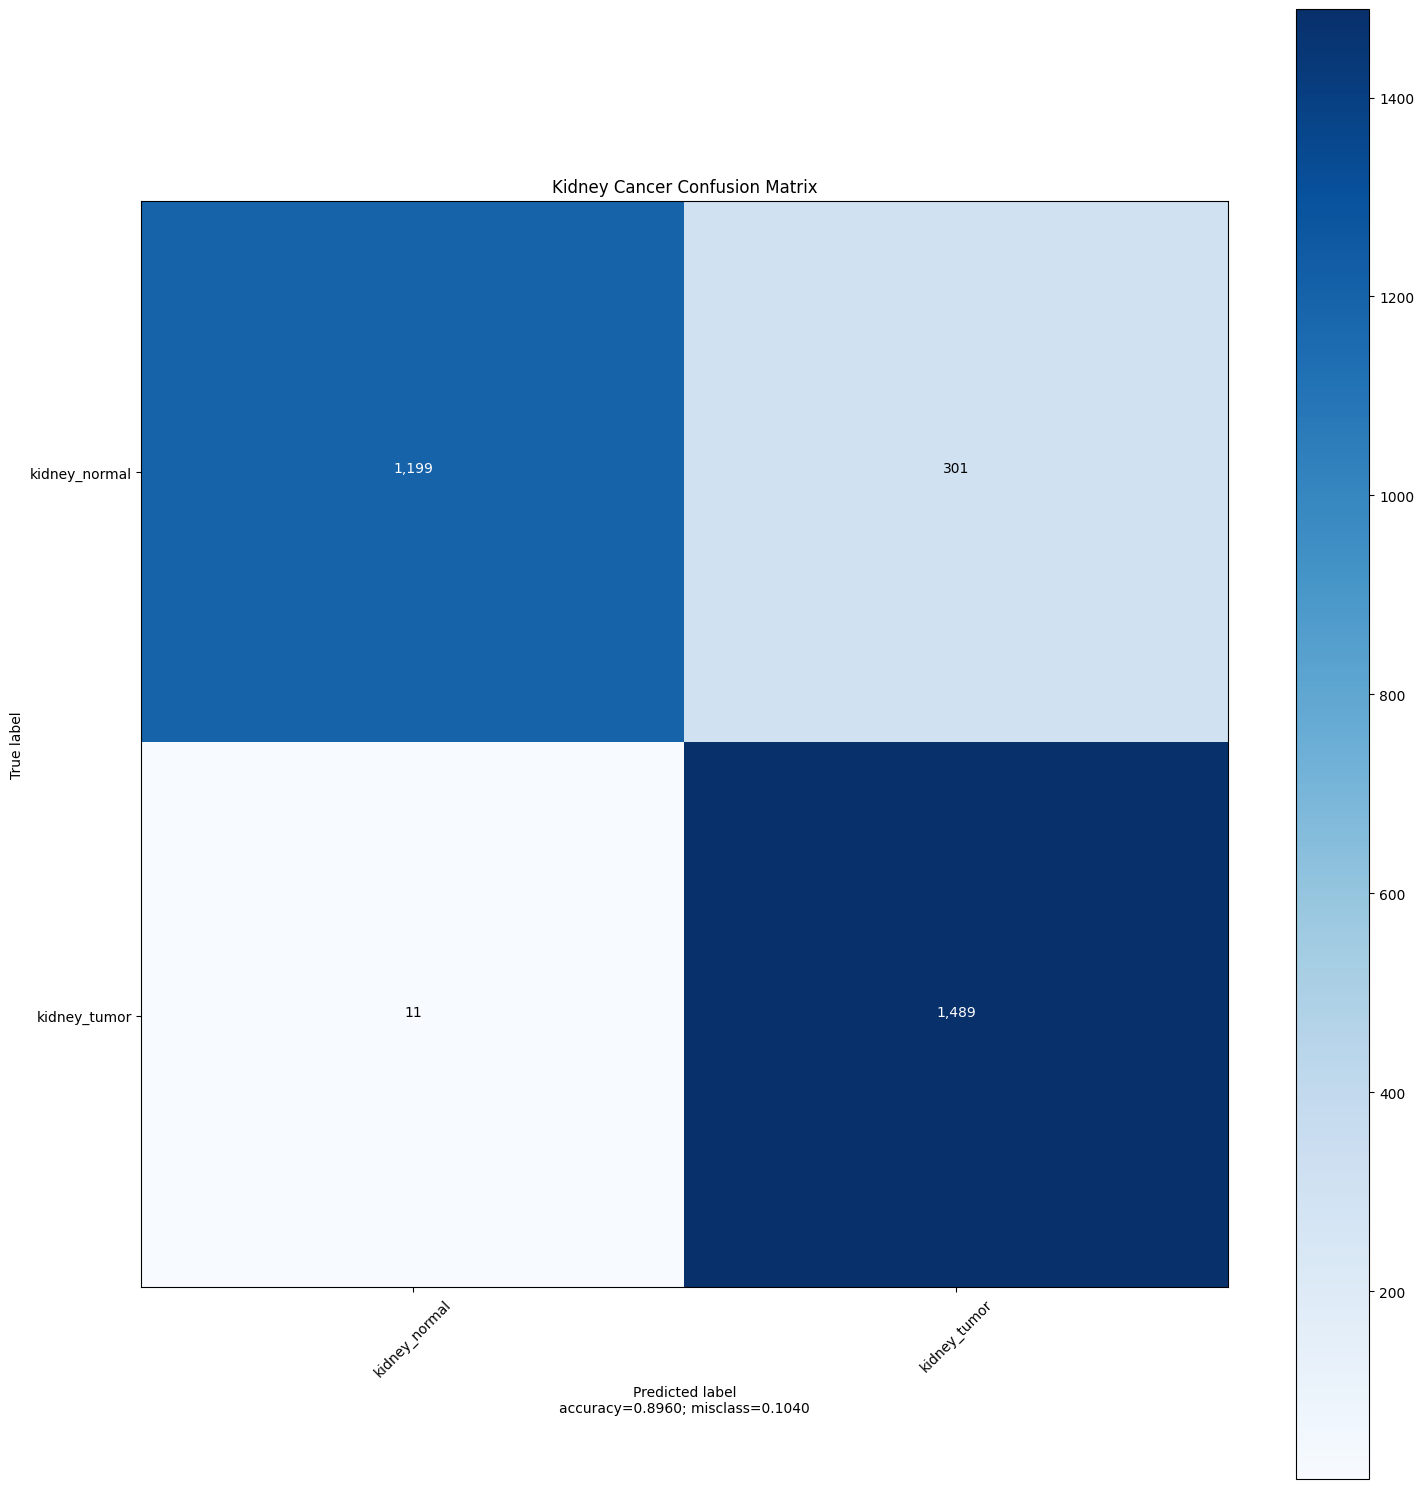

Best Hyperparameters (learning rate, batch size): [9.95284511e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [30]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
2 ['breast_benign', 'breast_malignant'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7951d878dfc0> <keras.src.preprocessing.image.DirectoryIterator object at 0x7951d878dae0>
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                

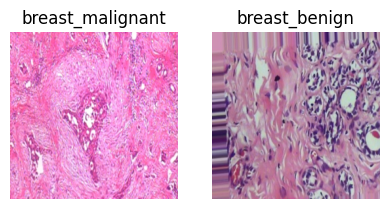

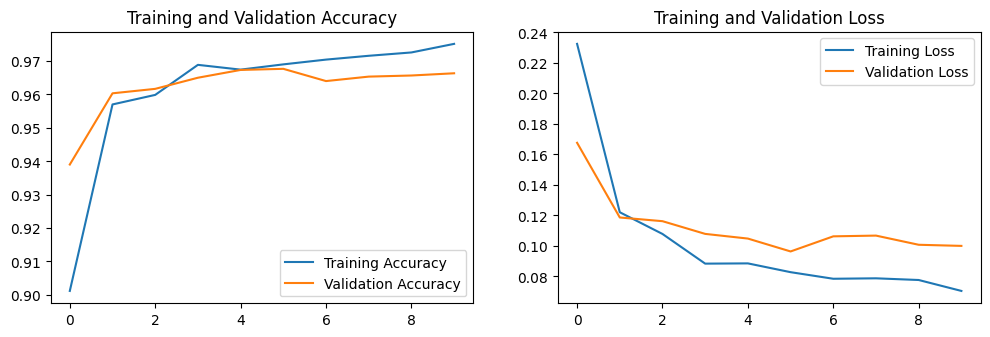

94/94 [==============================] - 21s 225ms/step - loss: 0.0999 - tp: 2899.0000 - fp: 101.0000 - tn: 2899.0000 - fn: 101.0000 - precision: 0.9663 - recall: 0.9663 - accuracy: 0.9663 - auc: 0.9923
Accuracy on the Test Set = 96.63 %
True Positives = 2899.0. True Negatives = 2899.0
False Positives = 101.0. False Negatives = 101.0
Precision = 0.9663333296775818
Recall = 0.9663333296775818
F1 Score = 96.63333296775818
ROC AUC = 0.9923208355903625
Model saved at: /kaggle/working/Breast Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 21s 218ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

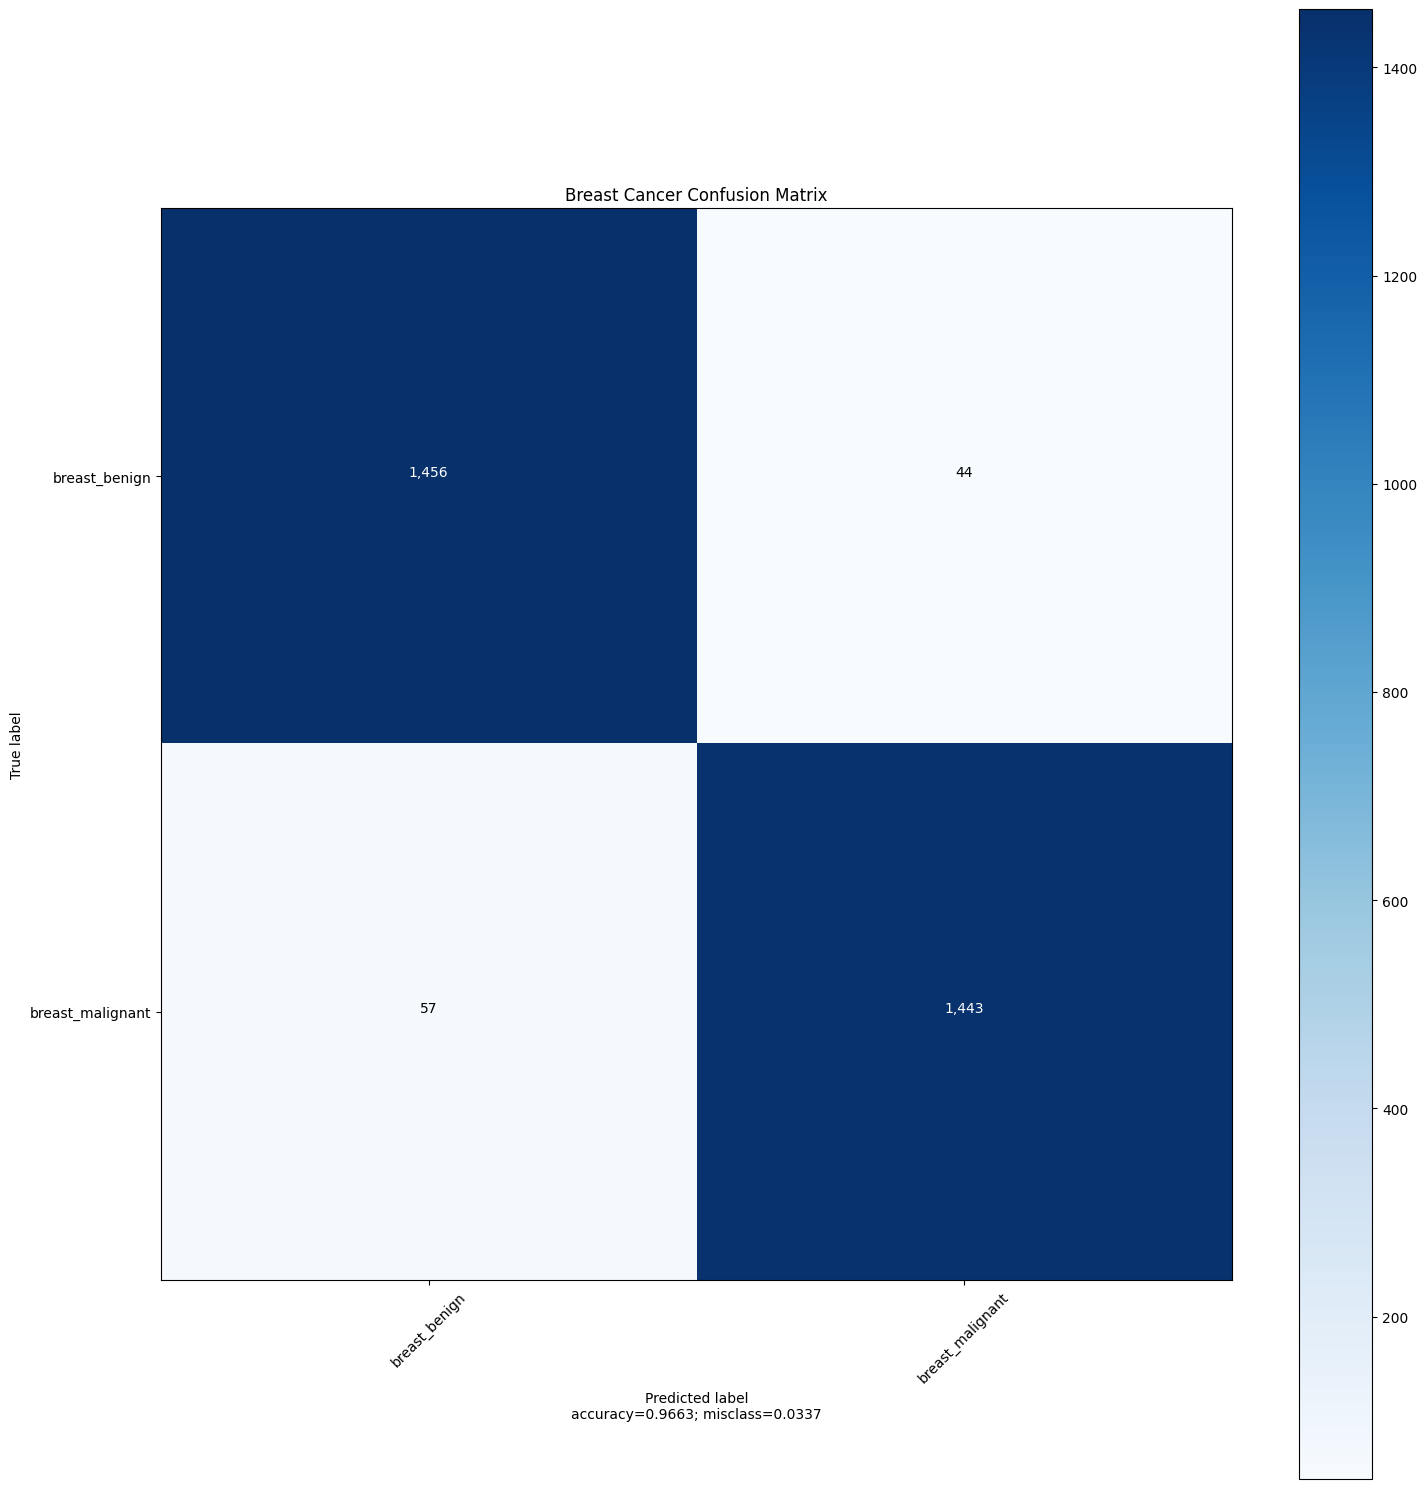

Best Hyperparameters (learning rate, batch size): [9.95284600e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [31]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
3 ['lymph_cll', 'lymph_fl', 'lymph_mcl'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7951db2d8850> <keras.src.preprocessing.image.DirectoryIterator object at 0x7951db2d8430>
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                             

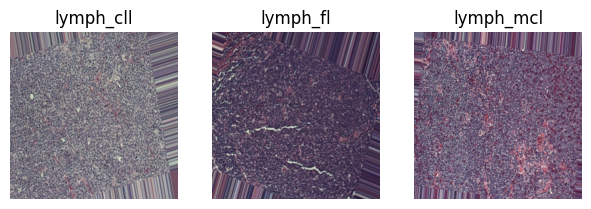

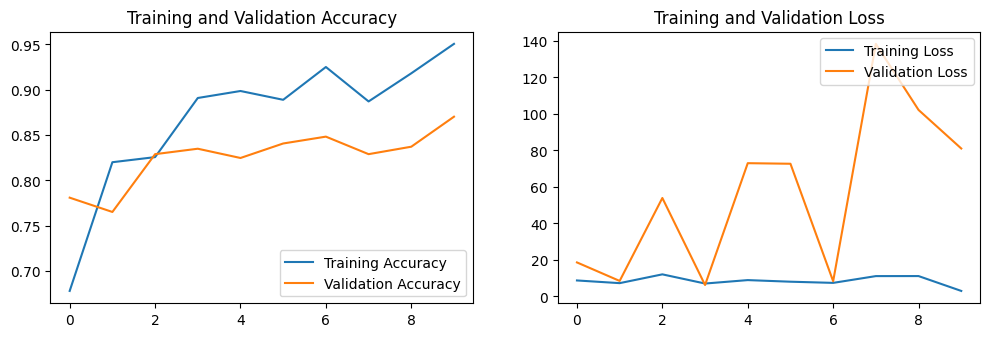

141/141 [==============================] - 18s 123ms/step - loss: 81.0447 - tp: 3916.0000 - fp: 584.0000 - tn: 8416.0000 - fn: 584.0000 - precision: 0.8702 - recall: 0.8702 - accuracy: 0.8702 - auc: 0.9099
Accuracy on the Test Set = 87.02 %
True Positives = 3916.0. True Negatives = 8416.0
False Positives = 584.0. False Negatives = 584.0
Precision = 0.8702222108840942
Recall = 0.8702222108840942
F1 Score = 87.02222108840942
ROC AUC = 0.9099162220954895
Model saved at: /kaggle/working/Lymphoma  - VGG16.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 17s 117ms/step
Predicted :  [0 0 0 ... 0 1 1]


<Figure size 640x480 with 0 Axes>

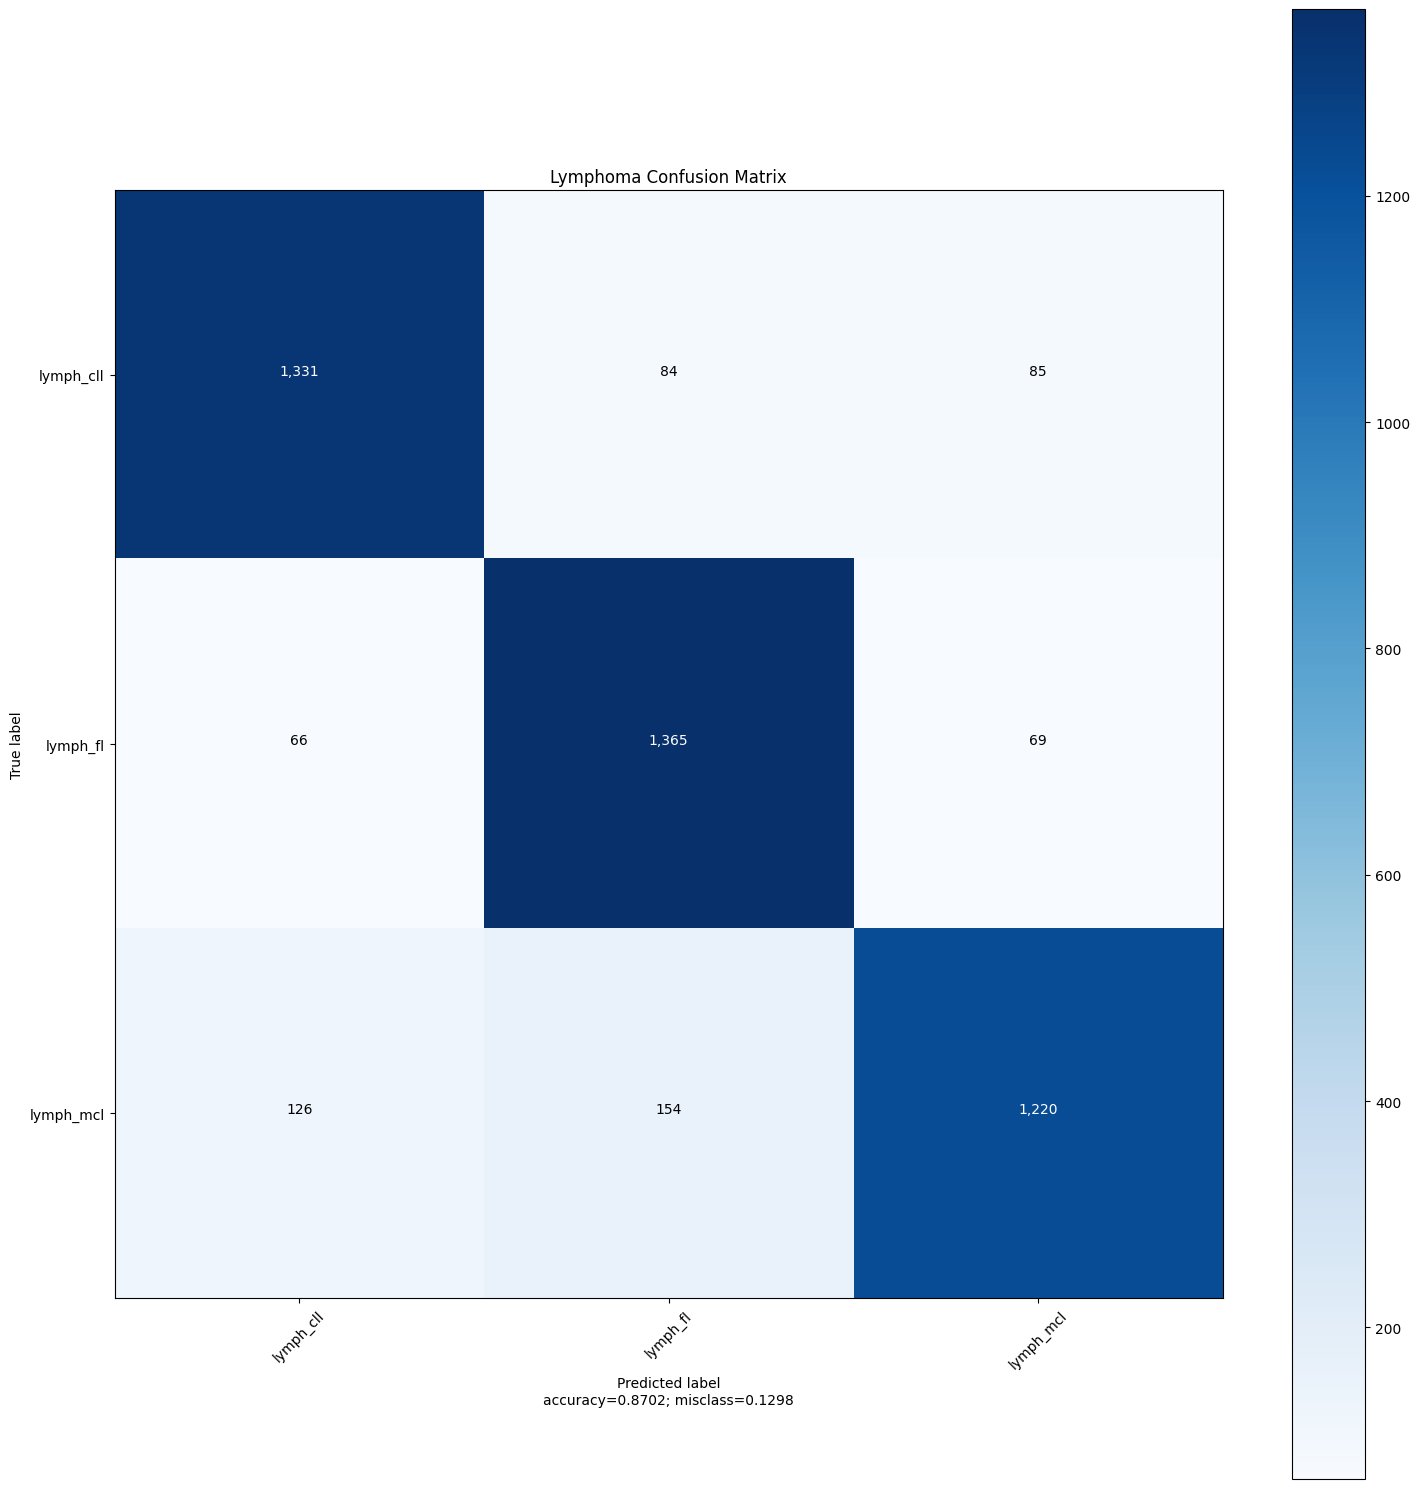

Best Hyperparameters (learning rate, batch size): [9.95284599e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [32]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
3 ['brain_glioma', 'brain_menin', 'brain_tumor'] <keras.src.preprocessing.image.DirectoryIterator object at 0x7952045d5c90> <keras.src.preprocessing.image.DirectoryIterator object at 0x7951db2fbbb0>
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                             

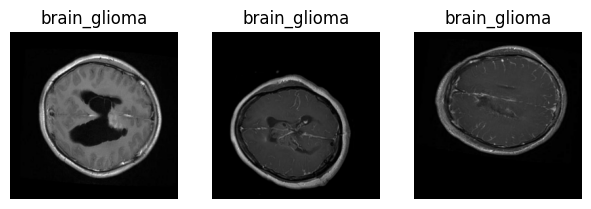

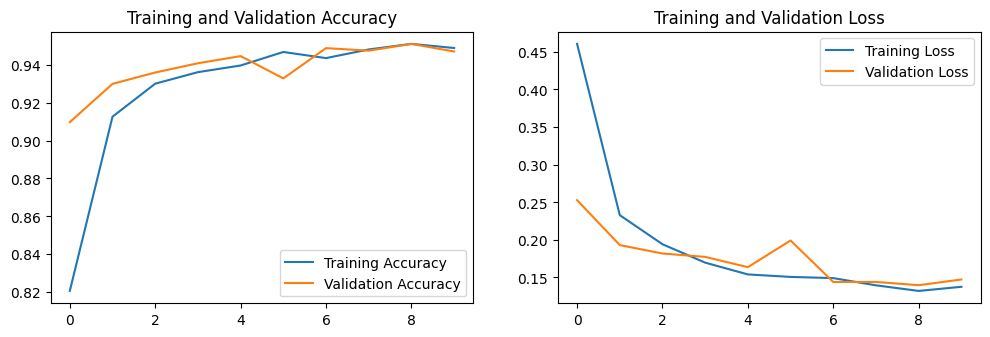

141/141 [==============================] - 13s 89ms/step - loss: 0.1473 - tp: 4253.0000 - fp: 228.0000 - tn: 8772.0000 - fn: 247.0000 - precision: 0.9491 - recall: 0.9451 - accuracy: 0.9471 - auc: 0.9929
Accuracy on the Test Set = 94.71 %
True Positives = 4253.0. True Negatives = 8772.0
False Positives = 228.0. False Negatives = 247.0
Precision = 0.9491184949874878
Recall = 0.945111095905304
F1 Score = 94.71105564545965
ROC AUC = 0.9929162859916687
Model saved at: /kaggle/working/Brain Cancer  - VGG16.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 12s 87ms/step
Predicted :  [0 1 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

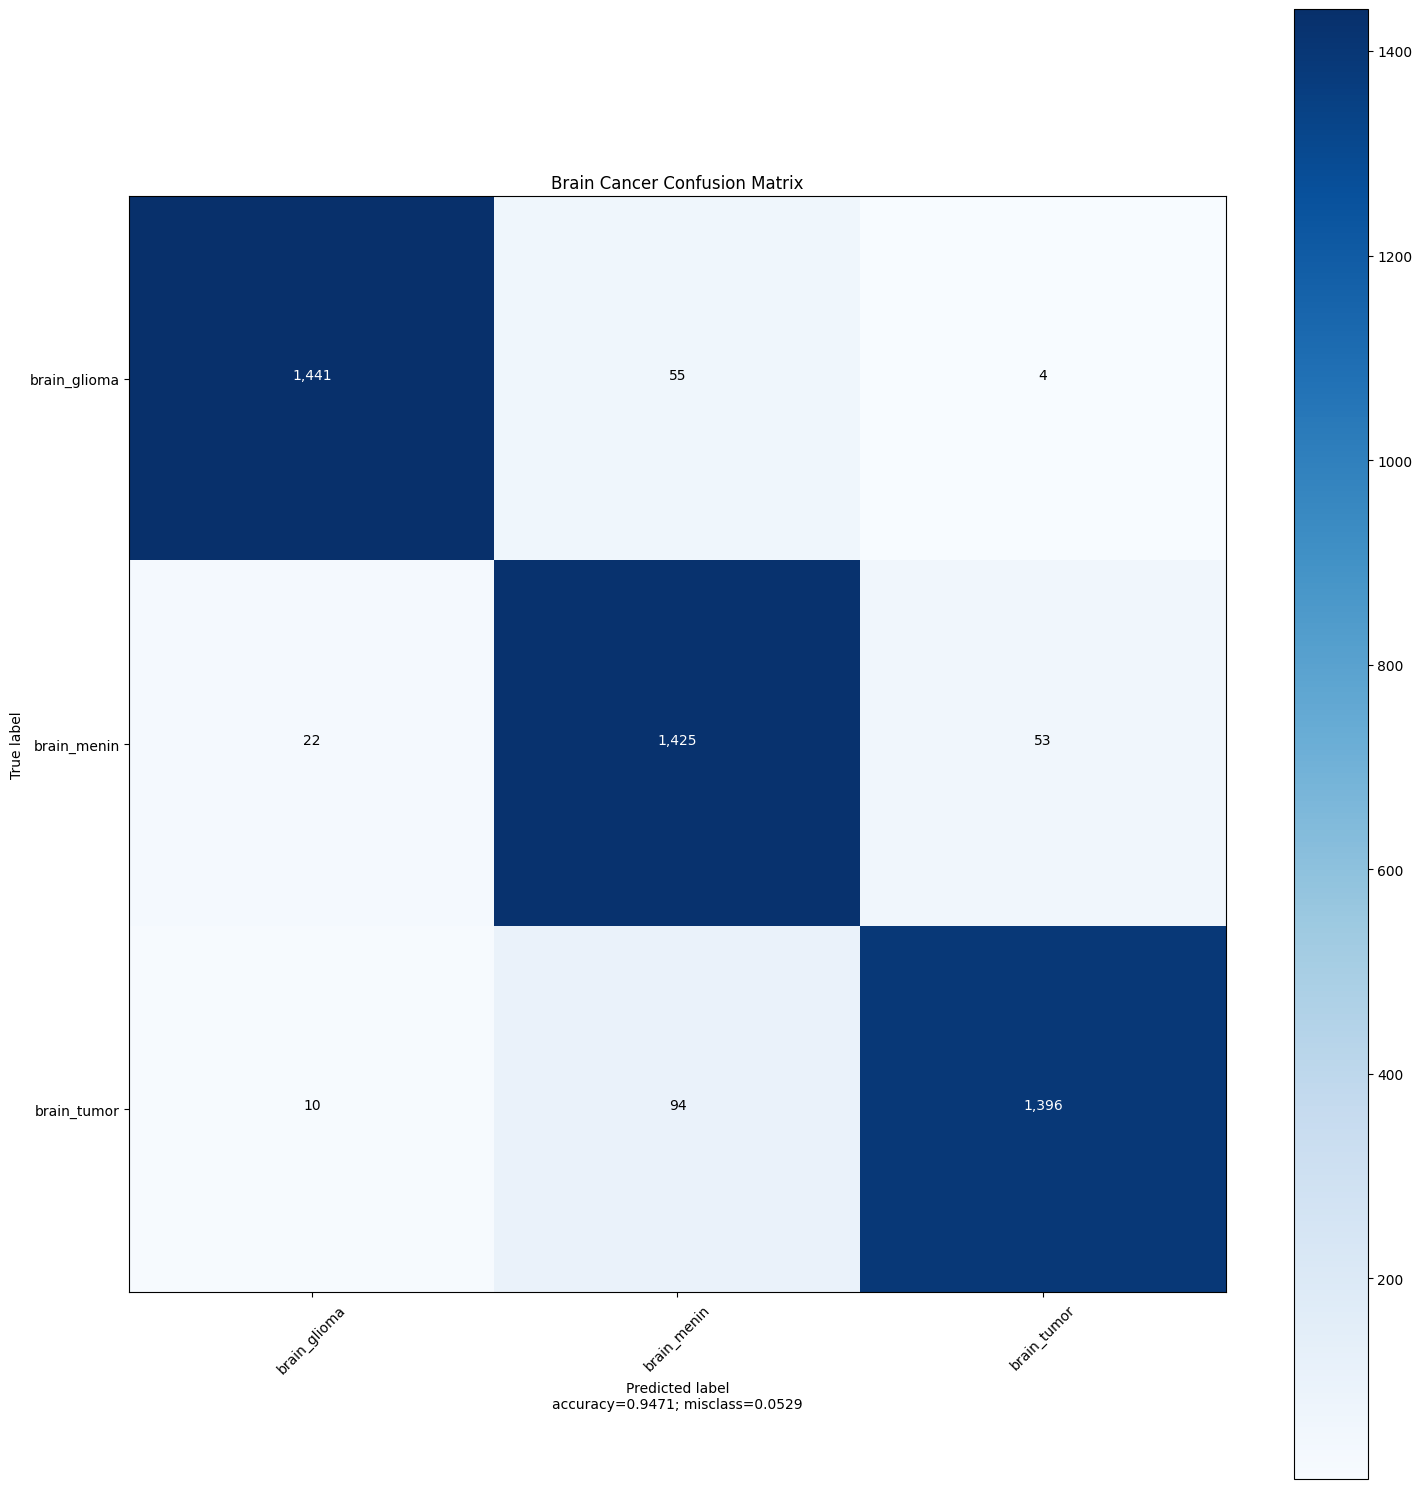

Best Hyperparameters (learning rate, batch size): [9.95284632e-03 2.55999963e+02]


/tmp/ipykernel_35/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [33]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)